In [139]:
from data_utils import CustomImageDataset
import torch
import os
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import tqdm
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt

In [140]:
plt.style.use("ggplot")

In [141]:
class Encoder(nn.Module):
    def __init__(self, latent_dims, input_c, input_dim):
        super(Encoder, self).__init__()
        self.linear1 = nn.Linear(input_c*input_dim*input_dim, 512)
        self.linear2 = nn.Linear(512, 128)
        self.linear3 = nn.Linear(128, latent_dims)

    def forward(self, x):
        x = torch.flatten(x, start_dim=1)
        x = F.relu(self.linear1(x))
        x = F.relu(self.linear2(x))
        return self.linear3(x)


class Decoder(nn.Module):
    def __init__(self, latent_dims, input_c, input_dim):
        self.input_c = input_c
        self.input_dim = input_dim
        super(Decoder, self).__init__()
        self.linear1 = nn.Linear(latent_dims, 128)
        self.linear2 = nn.Linear(128, 512)
        self.linear3 = nn.Linear(512, input_c*input_dim*input_dim)
        

    def forward(self, z):
        z = F.relu(self.linear1(z))
        z = F.relu(self.linear2(z))
        z = torch.sigmoid(self.linear3(z))
        return z.reshape((-1, self.input_c, self.input_dim, self.input_dim))
    

class Autoencoder(nn.Module):
    def __init__(self, latent_dims=16, input_c=1, input_dim=50):
        super(Autoencoder, self).__init__()
        self.encoder = Encoder(latent_dims, input_c, input_dim)
        self.decoder = Decoder(latent_dims, input_c, input_dim)

    def forward(self, x):
        z = self.encoder(x)
        return self.decoder(z)

In [142]:
torch.manual_seed(0)

In [143]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Using device:', device)

Using device: cuda


In [144]:
batch_size = 128

In [145]:
# transform = transforms.Compose(
#     [transforms.ToPILImage(),
#      transforms.ToTensor(),
#      transforms.Normalize(mean=(0), std=(1)),
#      transforms.Resize((28, 28)),
#      transforms.RandomAdjustSharpness(9, p=1),
#      ])
# transform = transforms.Compose(
#     [transforms.ToPILImage(),
#      transforms.ToTensor(),
#      transforms.Normalize(mean=(0), std=(1)),
#      transforms.Resize((28, 28)),
#      transforms.RandomAdjustSharpness(9, p=1),
#      transforms.Grayscale(1),
#      ])
transform = transforms.Compose(
    [transforms.ToPILImage(),
     transforms.ToTensor(),
     transforms.Normalize(mean=(0), std=(1)),
     transforms.RandomAdjustSharpness(5, p=1),
     transforms.Resize((28, 48)),
     transforms.CenterCrop((28, 28)),
     transforms.GaussianBlur(3),
     ])

In [146]:
train_data_path = "./homework_2_dataset/dataset/train"
train_dataset = CustomImageDataset(os.path.join(train_data_path, "annotation.txt"), os.path.join(train_data_path, "imgs"), transform=transform)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

In [147]:
proliv_data_path = "./homework_2_dataset/dataset/proliv"
proliv_dataset = CustomImageDataset(os.path.join(proliv_data_path, "annotation.txt"), os.path.join(proliv_data_path, "imgs"), transform=transform)
proliv_dataloader = DataLoader(proliv_dataset, batch_size=batch_size, shuffle=True)

In [148]:
test_data_path = "./homework_2_dataset/dataset/test"
test_dataset = CustomImageDataset(os.path.join(test_data_path, "annotation.txt"), os.path.join(test_data_path, "imgs"), transform=transform)
test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=True)

In [149]:
model = Autoencoder(input_c=3, input_dim=28, latent_dims=16).to(device)
opt = torch.optim.Adam(model.parameters())

for epoch in tqdm.tqdm(range(2)):
    model.train()
    train_count = 0
    running_loss = 0
    for x, y in train_dataloader:
        train_count += 1
        x = x.to(device) # GPU
        opt.zero_grad()
        x_hat = model(x)
        loss = ((x - x_hat)**2).sum()
        running_loss += loss / batch_size
        loss.backward()
        opt.step()
    
    model.eval()
    val_count = 0
    val_loss = 0   
    with torch.no_grad():
        for x, y in proliv_dataloader:
            val_count += 1
            x = x.to(device) # GPU
            reconstruction = model(x)
            loss = ((x - reconstruction)**2).sum()
            val_loss += loss / batch_size
    print(f"epoch {epoch}: train loss {running_loss / train_count}, validation loss {val_loss / val_count}")

  0%|          | 0/2 [00:00<?, ?it/s]e:\2023_processing_and_generating_images_course_homeworks\venv\Lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


 50%|█████     | 1/2 [00:11<00:11, 11.43s/it]

epoch 0: train loss 5.476001739501953, validation loss 15.770825386047363


100%|██████████| 2/2 [00:22<00:00, 11.44s/it]

epoch 1: train loss 4.149158000946045, validation loss 15.938910484313965


In [150]:
model.eval()
proliv_dataloader = DataLoader(proliv_dataset, batch_size=1, shuffle=True)
with torch.no_grad():
    losses = []
    true = []

    for x, y in proliv_dataloader:

        true.append(int(y[0]))
        x = x.to(device) # GPU
        reconstruction = model(x)
        loss = ((x - reconstruction)**2).sum()
        losses.append(loss.item())

thresolds, tp_rate = [], []
best_tresholds = []
for thresh in range(1, 6000, 1):
    tp, fp, tn, fn = 0, 0, 0, 0
    for loss, y in zip(losses, true):
        if loss >= (thresh / 100):
            y_pred = 1
        else:
            y_pred = 0
        
        if y == 1 and y_pred == 1:
            tp += 1
        elif y == 1 and y_pred == 0:
            fn += 1
        elif y == 0 and y_pred == 1:
            fp += 1
        elif y == 0 and y_pred == 0:
            tn += 1
    
    thresolds.append(thresh / 100)
    tp_rate.append(tp / (tp + fn))

    if tp / (tp + fn) == 1:
        best_tresholds.append(thresh / 100)
        # print(f"threshold = {(thresh / 100):.2f}: True Positive Rate: {(tp / (tp + fn)):.2f}")

if len(best_tresholds) > 0:
    print(f"choosen threshold: {np.quantile(best_tresholds, 0.9)}")
else:
    print("no possible thresholds")

choosen threshold: 12.619


In [151]:

tp, fp, tn, fn = 0, 0, 0, 0
for x, y in test_dataloader:

    x = x.to(device) # GPU
    reconstruction = model(x)
    loss = ((x - reconstruction)**2).sum()

    if loss >= np.quantile(best_tresholds, 0.9):
        y_pred = 1
    else:
        y_pred = 0
    
    if int(y[0]) == 1 and y_pred == 1:
        tp += 1
    elif int(y[0]) == 1 and y_pred == 0:
        fn += 1
    elif int(y[0]) == 0 and y_pred == 1:
        fp += 1
    elif int(y[0]) == 0 and y_pred == 0:
        tn += 1
    
tp_rate = tp / (tp + fn)
tn_rate = tn / (tn + fp)

print(f"True Positive Rate: {(tp / (tp + fn)):.3f}, True Negative Rate: {(tn / (tn + fp)):.3f}, Threshold: {np.quantile(best_tresholds, 0.9)}")

True Positive Rate: 0.969, True Negative Rate: 0.816, Threshold: 12.619


In [152]:
model.eval()
with torch.no_grad():
    losses = []
    true = []

    for x, y in test_dataloader:

        true.append(int(y[0]))
        x = x.to(device) # GPU
        reconstruction = model(x)
        loss = ((x - reconstruction)**2).sum()
        losses.append(loss.item())

thresolds, tp_rate, tn_rate = [], [], []
for thresh in range(1, 6000, 1):
    tp, fp, tn, fn = 0, 0, 0, 0
    for loss, y in zip(losses, true):
        if loss >= (thresh / 100):
            y_pred = 1
        else:
            y_pred = 0
        
        if y == 1 and y_pred == 1:
            tp += 1
        elif y == 1 and y_pred == 0:
            fn += 1
        elif y == 0 and y_pred == 1:
            fp += 1
        elif y == 0 and y_pred == 0:
            tn += 1
    
    thresolds.append(thresh / 100)
    tp_rate.append(tp / (tp + fn))
    tn_rate.append(tn / (tn + fp))

    if tp / (tp + fn) > 0.91 and tn / (tn + fp) > 0.91:
        print(f"threshold = {(thresh / 100):.2f}: True Positive Rate: {(tp / (tp + fn)):.3f}, True Negative Rate: {(tn / (tn + fp)):.3f}")

threshold = 14.69: True Positive Rate: 0.915, True Negative Rate: 0.910
threshold = 14.70: True Positive Rate: 0.915, True Negative Rate: 0.911
threshold = 14.71: True Positive Rate: 0.915, True Negative Rate: 0.911
threshold = 14.72: True Positive Rate: 0.915, True Negative Rate: 0.912
threshold = 14.73: True Positive Rate: 0.915, True Negative Rate: 0.912
threshold = 14.74: True Positive Rate: 0.915, True Negative Rate: 0.912
threshold = 14.75: True Positive Rate: 0.915, True Negative Rate: 0.912
threshold = 14.76: True Positive Rate: 0.915, True Negative Rate: 0.912
threshold = 14.77: True Positive Rate: 0.915, True Negative Rate: 0.912
threshold = 14.78: True Positive Rate: 0.915, True Negative Rate: 0.912
threshold = 14.79: True Positive Rate: 0.915, True Negative Rate: 0.912
threshold = 14.80: True Positive Rate: 0.915, True Negative Rate: 0.913
threshold = 14.81: True Positive Rate: 0.915, True Negative Rate: 0.913
threshold = 14.82: True Positive Rate: 0.915, True Negative Rate

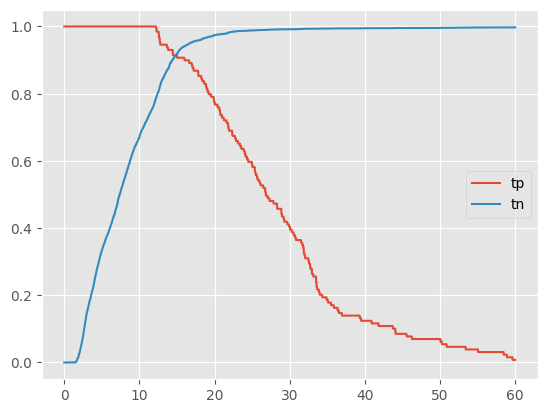

In [153]:
plt.plot(thresolds, tp_rate, label="tp")
plt.plot(thresolds, tn_rate, label="tn")
plt.legend() 
plt.show()

In [154]:
torch.save(model.state_dict(), "./autoencoders/AE")